In [1]:
# Libraries needed to run the notebook

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data reading

We retrieve data from the folder downloaded from kaggle and create a dataset in CSV format that includes all image paths and their corresponding categories as labels. 
The dataset will consist of the following columns:
- *image_path:* The path in the pc for the image
- *label:* The class to which the image belongs to


In [2]:
df = pd.DataFrame(columns=['image_path', 'label'])

# labels is a dictionary which maps a path to its specific label. 
labels = {'C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\cloudy\\' : 'Cloudy',
          'C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\desert\\' : 'Desert',
          'C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\green_area\\' : 'Green_Area',
          'C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\water\\' : 'Water',
           }

In [3]:
# Loop over all the folders of the dataset and extract the image path and label
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        new_row = pd.Series({'image_path': image_path, 'label': label})
        df = pd.concat([df, new_row.to_frame().transpose()], ignore_index=True)

# Saving the Dataframe to into a CSV file
df.to_csv('satellite_images_dataset.csv', index=False)

In [4]:
df = pd.read_csv('satellite_images_dataset.csv')

# Printing only the first 10 rows to provide an overview of the dataset
df

,image_path,label
0,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Cloudy
1,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Cloudy
2,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Cloudy
3,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Cloudy
4,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Cloudy
...,...,...
5626,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Water
5627,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Water
5628,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Water
5629,C:\Users\nephr\Desktop\Uni Nuova\FDS\FDS_PROJE...,Water


Let's dig into the dataset, which comprises 5631 rows distributed among four distinct classes. Using the 'value_counts()' function we can calculate how many images fall into each category:
1. *Cloudy:* 1500 images
2. *Desert:* 1131 images
3. *Green_Area:* 1500 images
4. *Water:* 1500 images

The dataset appears to be evenly distributed across these categories.

In [5]:
# We count the number of images for each category and put it in a dictionary
label_counts = df['label'].value_counts()

label_counts = dict(sorted(label_counts.items()))

print(label_counts)

{'Cloudy': 1500, 'Desert': 1131, 'Green_Area': 1500, 'Water': 1500}


Now, let's create a graphical representation of the total number of images for each category in the dataset we've just created:

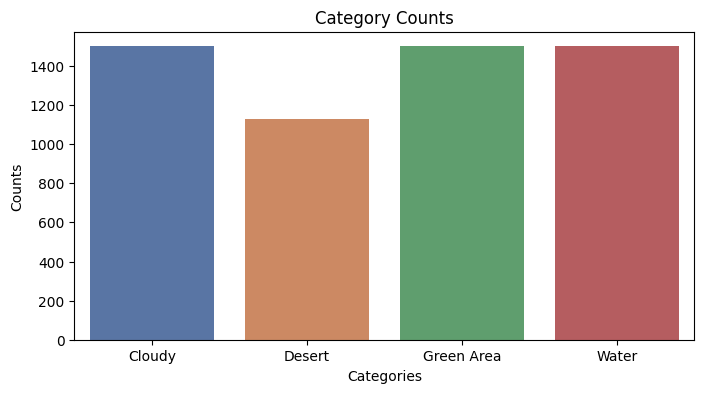

In [6]:

plt.figure(figsize=(8, 4))
colors = ['gray', 'orange', 'light_green', 'red']
sns.barplot(x=list(label_counts.keys()), y= list(label_counts.values()), hue=list(label_counts.keys()), palette='deep', legend=False)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Category Counts')
plt.xticks(range(4),labels = ["Cloudy", "Desert", "Green Area", "Water"])
plt.show()

# 2. Data Pre-processing

Now, it's time to perform data splitting for training and testing, along with pre-processing. We have opted for an *80-20 split* for training and testing due to the relatively small size of the dataset. If the accuracy proves to be unsatisfactory, we will consider experimenting with a *90-10 split*.
We'll be using the already implemented function 'train_test_split' to split the dataset

In [7]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=95)

In the Pre-processing phase, we created a code to prepare the train and test datasets for training and testing a machine learning model.

Firstly, the *train_datagen* configuration applies various image transformations to the train dataset, such as shear, zoom, horizontal and vertical flips, and rotation. The purpose is to diversify the training data, enabling the model to learn more different features and improve robustness.

Followingly, for the *test_datagen*, the main goal is just to ensure that the data is normalized in the same way as the training set. Thus, we didn't apply all the tranformations we did in the train_datagen since the goal is to evaluate the model's performance on unaltered real-world data.

Furthermore, the rescale=1./255 parameter scales pixel values to the range [0, 1] and is done for both the training and testing datasets to ensure that pixel values fall within a standardized range.

Lastly, The flow_from_dataframe method is used to create data generators from both the training and testing datasets. This method links the image paths and labels from the DataFrame to the generator.


In [8]:
# Configuration of the data generator for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalization of pixel values to the range [0, 1]
    shear_range=0.2,          # Shear transformation with a maximum angle of 0.2
    zoom_range=0.2,           # Zoom transformation with a maximum scale of 0.2
    width_shift_range=0.2,    # Randomly shifts the width of images by 20% of the total width
    height_shift_range=0.2,   # Randomly shifts the height of images by 20% of the total height
    horizontal_flip=True,     # Applies horizontal flip to images
    rotation_range=45,        # Randomly rotates images up to 60 degrees
    vertical_flip=True,       # Applies vertical flip to images
    fill_mode='nearest'       # Fill mode for pixels after transformations
)

# Configuration of the data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255) # Just normalization

# Creating the data generator for the training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                # DataFrame containing information about training images and labels
    x_col="image_path",                # Column containing the paths of the images
    y_col="label",                     # Column containing the labels
    target_size=(255, 255),            # Target size of the images
    batch_size=32,                     # Number of images processed in a single iteration
    class_mode="categorical"           # Labels are provided as categorical class labels (using one-hot encoding) 
)

# Creating the data generator for the test set
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(255, 255),
    batch_size=32,
    class_mode="categorical"
)


Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


Now let's visually represent the pre-processed training data:

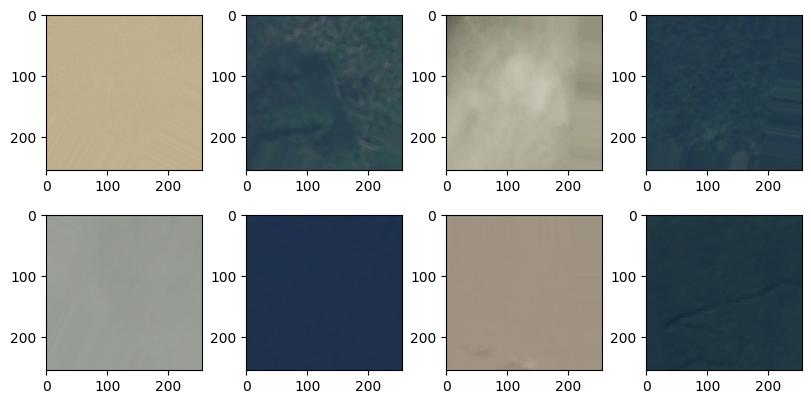

In [9]:
# Creates a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(8, 4), constrained_layout=True)

# Generates and display 8 images from the training generator
for i in range(2):
    for j in range(4):
        img, label = train_generator.next()  # Takes the next batch from the generator
        axes[i, j].imshow(img[0])
        axes[i, j].axis('on')

plt.show()

And now let's visualize some examples from the pre-processed test dataset too:

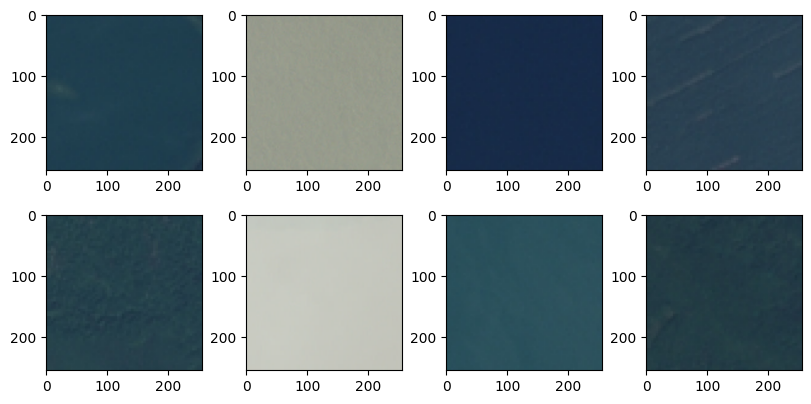

In [10]:
# Creates a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(8, 4), constrained_layout=True)

# Generates and display 8 images from the training generator
for i in range(2):
    for j in range(4):
        img, label = test_generator.next()  # Takes the next batch from the generator
        axes[i, j].imshow(img[0])
        axes[i, j].axis('on')

plt.show()

# 3. Model Creation

In the following code we defined a Convolutional Neural Network (CNN) model using the Keras library from the TensorFlow framework. This model architecture is specifically designed for image classification tasks.

The structure of the model involves a sequence of convolutional layers, pooling layers for downsampling, fully connected layers, and dropout regularization.
We decided to use this structure of layers since it's commonly used among other CNN model training works


Lastly, the model compiled with the Adam optimizer, a popular optimizer used in artificial neural networks for weight optimization, categorical cross-entropy loss function, which is a function suitable for multi-class classification, and accuracy as the evaluation metric.

In [13]:
def create_model():
    model = keras.models.Sequential([
        # First convolutional layer with 32 filters, each of size (2,2)
        layers.Conv2D(32, (2,2), activation='relu', input_shape=(255, 255, 3)),
        layers.MaxPooling2D(2,2),

        # Second convolutional layer with 64 filters, each of size (2,2)
        layers.Conv2D(64, (2,2), activation='relu'), #second convolutional layer
        layers.MaxPooling2D(2,2),

        # Third convolutional layer with 64 filters, each of size (3,3)
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # Flatten layer to convert 3D feature maps to 1D feature vectors
        layers.Flatten(),

        # Dropout layer with a dropout rate of 0.1 to prevent overfitting
        layers.Dropout(0.1),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),

        # Output layer with 4 neurons
        layers.Dense(4, activation='softmax')
    ])

    # Model compilation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #compile the model with adam optimizer
    return model



# 4. Model Training and Accuracy Testing

In the following code we used the previously defined function "create_model" to instantiate a model and we trained it using the  pre-implemented Keras function 'fit()', which takes in input:
- *train_generator:* the training data generator
- *epochs:* the number of training epochs
- *verbose:* Controls the display of progress during training
- *validation_data:* Specifies the validation dataset to be used during training

We chose *11 epochs* since generally, this is generally considered an optimal number for training on most datasets. 
A smaller number might lead to underfitting, as the training process relies on iterations of gradient descent. On the other hand, too many epochs can cause the model to overfit.


In [14]:
# Creating an instance of the untrained model
model = create_model()

# Training the creared model
history = model.fit(train_generator,
                    epochs=11,
                    verbose=1,
                    validation_data=test_generator)

Epoch 1/11
141/141 [==============================] - 99s 693ms/step - loss: 0.7022 - accuracy: 0.6823 - val_loss: 0.3688 - val_accuracy: 0.8385
Epoch 2/11
141/141 [==============================] - 95s 670ms/step - loss: 0.3519 - accuracy: 0.8495 - val_loss: 0.3934 - val_accuracy: 0.8101
Epoch 3/11
141/141 [==============================] - 95s 675ms/step - loss: 0.3295 - accuracy: 0.8599 - val_loss: 0.2554 - val_accuracy: 0.8980
Epoch 4/11
141/141 [==============================] - 96s 677ms/step - loss: 0.2934 - accuracy: 0.8803 - val_loss: 0.2614 - val_accuracy: 0.8820
Epoch 5/11
141/141 [==============================] - 96s 682ms/step - loss: 0.2925 - accuracy: 0.8788 - val_loss: 0.2340 - val_accuracy: 0.9157
Epoch 6/11
141/141 [==============================] - 96s 677ms/step - loss: 0.2718 - accuracy: 0.8890 - val_loss: 0.2996 - val_accuracy: 0.8722
Epoch 7/11
141/141 [==============================] - 95s 676ms/step - loss: 0.2612 - accuracy: 0.8914 - val_loss: 0.2911 - val_ac

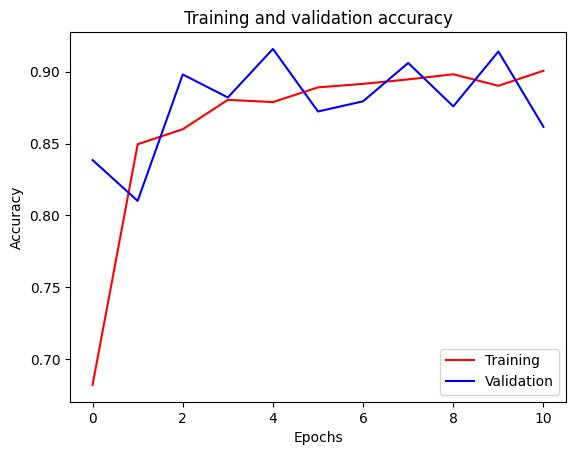

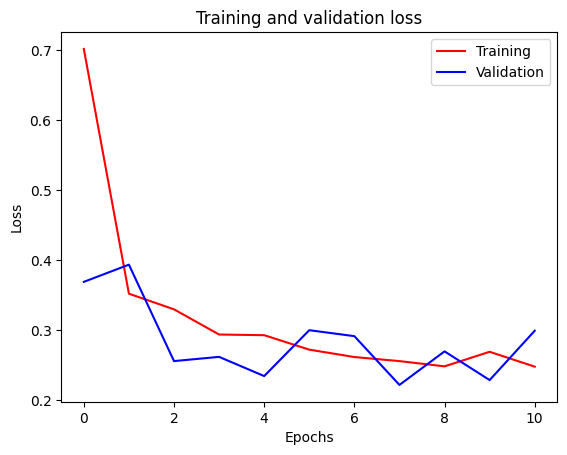

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Training and validation accuracy plot per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validation'])
plt.show()
print("")

# Training and validation loss plot per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])
plt.show()

In the first graph, we observe a gradual, non-uniform increase in accuracy, while in the second graph, there is a gradual, non-uniform decrease in loss.

An increased accuracy over epochs indicates that the model is learning and improving its predictions. Furthermore, a large divergence between training and validation accuracy might suggest overfitting.

# 5. Predictions and Confusion Matrix

The model created this way can be used to predict the class that the image belongs to. The accuracy of our prediction will depend on how well our model recognizes the true class of the image. 

In [16]:
#a function that takes an image as an input and returns a prediction of its class on account of the model we built
def prediction(img, mo):
    # Convert the image to an array
    img_array = img_to_array(img)
    # Normalize the image pixel values to the range [0, 1]
    img_array = img_array / 255.0 #because the shape is 255
    img_array = np.reshape(img_array, (1, 255, 255, 3))
    # Get the model predictions
    predictions = mo.predict(img_array)
    class_index = np.argmax(predictions[0])
    # Get the class index with the highest predicted probability
    class_index = np.argmax(predictions[0])
    # Get the predicted class label
    count=0
    for i in labels.values():
        if(count==class_index):
            predicted_label = i
        count=count+1
    return(predicted_label)


We predicted the class for one randomly picked image chosen from each of the four classes. 

1/1 [==============================] - 0s 137ms/step
Label: Desert, Prediction: Desert


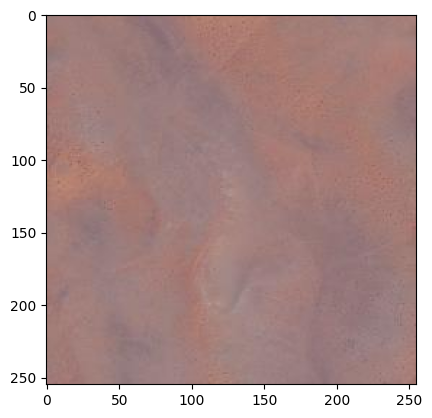

In [19]:
#a random image of desert

img1 = load_img('C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\desert\\desert(411).jpg', target_size=(255, 255))
plt.imshow(img1)
print('Label: Desert, Prediction:', prediction(img1, model))


1/1 [==============================] - 0s 20ms/step
Label: Green_area, Prediction: Green_Area


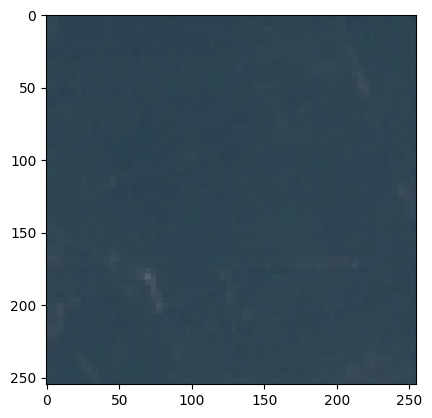

In [20]:
#a random image of green area
img2 = load_img('C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\green_area\\Forest_209.jpg', target_size=(255, 255))
plt.imshow(img2)
print('Label: Green_area, Prediction:', prediction(img2, model))

1/1 [==============================] - 0s 12ms/step
Label: Cloudy, Prediction: Cloudy


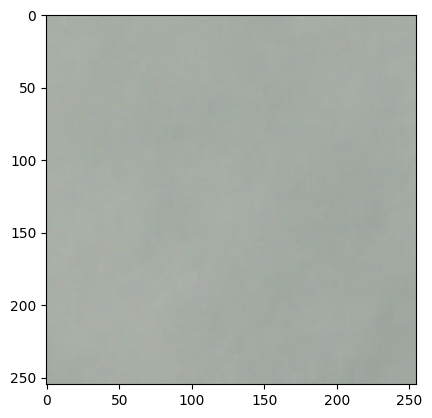

In [21]:
#a random image of coluds
img3 = load_img('C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\cloudy\\train_827.jpg', target_size=(255, 255))
plt.imshow(img3)
print('Label: Cloudy, Prediction:', prediction(img3, model))

1/1 [==============================] - 0s 20ms/step
Label: Water, Prediction: Water


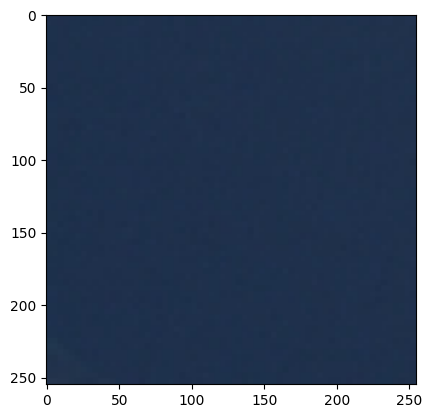

In [22]:
#a random image of water
img4 = load_img('C:\\Users\\nephr\\Desktop\\Uni Nuova\\FDS\\FDS_PROJECT\\satellite_image_dataset\\data\\water\\SeaLake_713.jpg', target_size=(255, 255))
plt.imshow(img4)
print('Label: Water, Prediction:', prediction(img4, model))

The model predicted well on all randomly picked images, but that does not guarantee its absolute accuracy. A confusion matrix can represent the accuracy of predictions better, since it will take into account the predictions for all the images in the dataset.

In [23]:

#making a list of the classes the images really belong to
y_true = []
for i in label_counts.keys():
    j=0
    while(j<label_counts[i]):
        y_true.append(i)
        j=j+1
y_true

#making a list of what are predictions are for each image
y_pred = []
for i in df['image_path']:
    img=load_img(i, target_size=(255, 255))
    y_pred.append(prediction(img,model))
print(y_pred)


1/1 [==============================] - 0s 27ms/step
['Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Desert', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy

Text(50.72222222222221, 0.5, 'Actual')

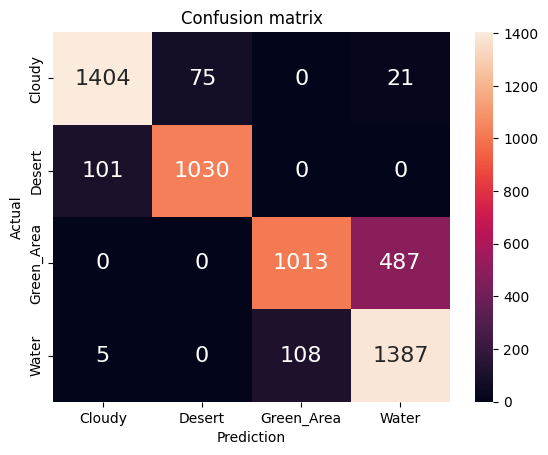

In [24]:
#confusion matrix
cm  = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cm, index = label_counts.keys(),
                  columns = label_counts.keys())
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [25]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

      Cloudy       0.93      0.94      0.93      1500
      Desert       0.93      0.91      0.92      1131
  Green_Area       0.90      0.68      0.77      1500
       Water       0.73      0.92      0.82      1500

    accuracy                           0.86      5631
   macro avg       0.87      0.86      0.86      5631
weighted avg       0.87      0.86      0.86      5631



# Softmax regression

Now, let's try the same analysis using Softmax Logistic regression to compare the difference in accuracy.

Softmax logistic regression can be viewed as simpler model than CNN with a single fully connected layer instead of multiple convolutional and pooling layers. In this case, the flatten layer serves to transform the two-dimensional image into a one-dimensional vector, meanwhile, the fully connected layer is responsible for transforming the input features into an output vector representing the probability of belonging to each class.

## Softmax regression model creation

In [26]:
def create_softmax_regression_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [27]:
input_shape = (255, 255, 3)  
num_classes = 4  # the number of classes (clouds, green area, water and deserts)

model_lr = create_softmax_regression_model(input_shape, num_classes)
model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Softmax regression model training and accuracy testing

In [28]:
epochs = 11
batch_size=32

history_lr = model_lr.fit(train_generator, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=test_generator)

Epoch 1/11
141/141 [==============================] - 40s 281ms/step - loss: 8.2864 - accuracy: 0.5855 - val_loss: 4.4608 - val_accuracy: 0.4845
Epoch 2/11
141/141 [==============================] - 39s 274ms/step - loss: 3.5527 - accuracy: 0.6437 - val_loss: 2.4014 - val_accuracy: 0.6877
Epoch 3/11
141/141 [==============================] - 39s 276ms/step - loss: 4.7573 - accuracy: 0.6439 - val_loss: 18.2337 - val_accuracy: 0.3975
Epoch 4/11
141/141 [==============================] - 39s 273ms/step - loss: 5.8459 - accuracy: 0.6670 - val_loss: 4.5261 - val_accuracy: 0.6309
Epoch 5/11
141/141 [==============================] - 39s 277ms/step - loss: 4.1070 - accuracy: 0.6672 - val_loss: 3.3861 - val_accuracy: 0.6886
Epoch 6/11
141/141 [==============================] - 39s 277ms/step - loss: 4.0969 - accuracy: 0.6676 - val_loss: 2.7015 - val_accuracy: 0.6584
Epoch 7/11
141/141 [==============================] - 39s 279ms/step - loss: 5.5229 - accuracy: 0.6576 - val_loss: 4.9886 - val_a

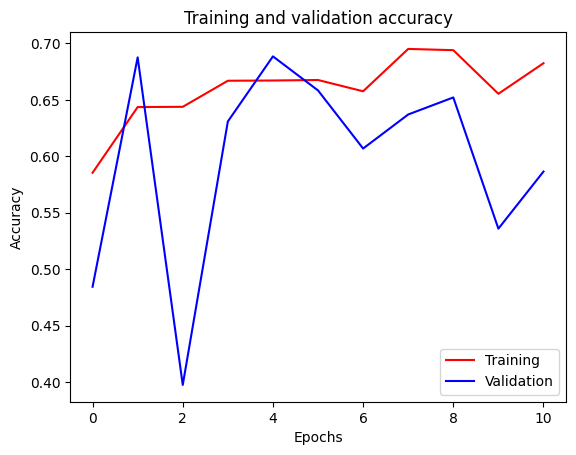

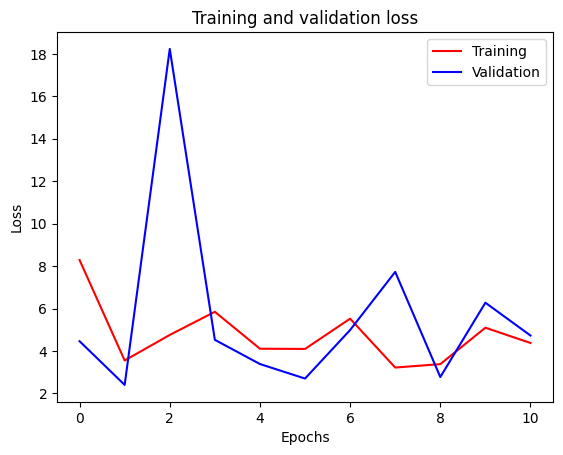

In [29]:
acc = history_lr.history['accuracy']
val_acc = history_lr.history['val_accuracy']
loss = history_lr.history['loss']
val_loss = history_lr.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Training and validation accuracy plot per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validation'])
plt.show()
print("")

# Training and validation loss plot per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])
plt.show()

We will make a similar analysis as we did for our CNN model: 

In [30]:
#making a list of what the predictions with our softmax regression model are for each image
y_pred = []
for i in df['image_path']:
    img=load_img(i, target_size=(255, 255))
    y_pred.append(prediction(img, model_lr))
print(y_pred)

1/1 [==============================] - 0s 20ms/step
['Desert', 'Water', 'Desert', 'Desert', 'Desert', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Desert', 'Cloudy', 'Desert', 'Desert', 'Desert', 'Desert', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Desert', 'Desert', 'Cloudy', 'Cloudy', 'Water', 'Desert', 'Desert', 'Cloudy', 'Cloudy', 'Desert', 'Desert', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Water', 'Desert', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Water', 'Desert', 'Cloudy', 'Cloudy', 'Desert', 'Desert', 'Desert', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Desert', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Desert', 'Water', 'Desert', 'Cloudy', 'Cloudy', 'Desert', 'Desert', 'Water', 'Desert', 'Cloudy', 'Desert', 'Desert', 'Water', 'Desert', 'Cloudy', 'Desert', 'Desert', 'Wat

Text(50.72222222222221, 0.5, 'Actual')

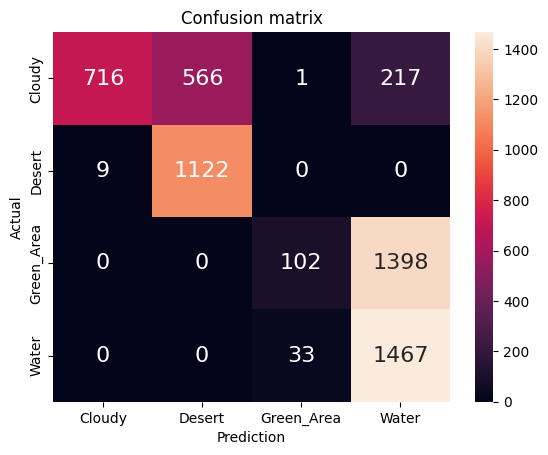

In [36]:
#confusion matrix
cm  = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cm, index = label_counts.keys(),
                  columns = label_counts.keys())
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [37]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

      Cloudy       0.99      0.48      0.64      1500
      Desert       0.66      0.99      0.80      1131
  Green_Area       0.75      0.07      0.12      1500
       Water       0.48      0.98      0.64      1500

    accuracy                           0.61      5631
   macro avg       0.72      0.63      0.55      5631
weighted avg       0.72      0.61      0.54      5631



As indicated by the statistics, the accuracy is approximately 20 percent lower when using softmax regression. This model is typically employed in scenarios where the classification problem is simpler and does not necessitate the learning of complex features through multiple convolutional layers.